In [105]:
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
os.listdir("../../data/prepared_data/")

['unpd_world.csv',
 'unpd_combined_indicators.csv',
 'e4a.csv',
 'gbd_world_pop.csv',
 'e4a_combined_labelled.csv',
 'combined_data.csv',
 'cumulative_births_combined.csv',
 'unpd_large.csv',
 'date_for_8bn.csv',
 'cumulative_births_unpd_all_countries.csv',
 'combined_birth_data.csv',
 'gbd_scenarios_pop.csv',
 'dependency_ratios.csv',
 'unpd_world_indicators.csv',
 'gbd_world_births.csv',
 'slide_data']

In [8]:
df = pd.read_csv("../../data/prepared_data/combined_data.csv")

In [19]:
df

,Unnamed: 0.1,index,Unnamed: 0,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,...,Q0060Female,Q1550,Q1550Male,Q1550Female,Q1560,Q1560Male,Q1560Female,NetMigrations,CNMR,BirthsSingle
0,0,0,0.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,498.0396,240.3164,271.6253,208.1916,378.6968,430.2594,324.9308,0.0,0.0,92083258.0
1,1,1,1.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,490.1993,231.1772,258.0905,203.7797,368.3186,415.8362,319.3364,0.0,0.0,92836900.0
2,2,2,2.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,477.2639,218.6745,240.0344,197.1422,353.0546,395.5327,309.9103,0.0,0.0,97606684.0
3,3,3,3.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,469.5325,212.8720,232.6019,193.0492,345.0826,385.8433,303.9053,0.0,0.0,97555839.0
4,4,4,4.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,458.4842,205.7622,224.0498,187.4439,335.4420,374.6576,295.9944,0.0,0.0,100348054.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43856346.0
716,716,238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43313897.0
717,717,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42804561.0
718,718,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42319098.0


In [49]:
""" Functions for extending projections on the basis of an AR(N) model
"""

def df_extender(df, **cols_to_input):
    ''' Generate a dataframe that extends the input

        df: original dataframe
        cols_to_input: key/val of colnames, lists of data

        everything not in cols_to_input is copied from first val
    '''
    new_cols = [c for c in df.columns if c not in cols_to_input.keys()]
    base_df = pd.DataFrame(cols_to_input,
            columns=df.columns)
    for col in new_cols:
        base_df[col] = df[col].iloc[0]

    return base_df

def extend_ar(grouped_df,
        lags,
        values_col="val",
        years_col="year_id",
        extrapolation_length=10):
    ''' Take a DF grouped by the scenario so we have a single timeseries
        and add an extra @n steps using an AR(lags) model
        don't rely on this for a long extrapolation with further analysis
    '''
    ts_len, df_cols = grouped_df.shape
    final_year_df = grouped_df[years_col].max()
    final_year_predict = final_year_df + extrapolation_length
    new_years = [year for year in range(final_year_df+1, final_year_predict+1)]

    ar_model = AutoReg(grouped_df[values_col].to_numpy(), lags=lags).fit()
    new_datapoints = ar_model.predict(ts_len, ts_len+extrapolation_length-1)
    new_fields = {values_col: new_datapoints, years_col: new_years}

    return pd.concat([grouped_df, 
        df_extender(grouped_df, **new_fields)]
        )


In [26]:
df_nona = df[df.BirthsSingle.notna()]

In [34]:
df_nona[df_nona.Time==2100].loc[:,["Variant","BirthsSingle"]]

,Variant,BirthsSingle
150,Medium,1.114537e+08
230,High,2.193278e+08
310,Low,4.813194e+07
394,Reference,7.927685e+07
477,SDG Met Need and Education,4.439472e+07
598,Great Leap,1.925485e+07
719,Too Little Too Late,4.182492e+07


In [58]:
extrap_len = 200
del df_comb_extend
df_comb_extend = df_nona.groupby("Variant").apply(extend_ar, 1, extrapolation_length=extrap_len, values_col="BirthsSingle", years_col="Time")

#df_comb_extend = df_nona # make a new df
for scenario in df_nona.Variant.unique():
    final_forecast_ref_val = df_nona[(df_nona.Variant==scenario) & (df_nona.Time==2100)].BirthsSingle
    df_comb_extend.loc[(df_comb_extend.Variant==scenario) & (df_comb_extend.Time > 2100),"BirthsSingle"] = extrap_len*[final_forecast_ref_val]

<Axes: xlabel='Time', ylabel='BirthsSingle'>

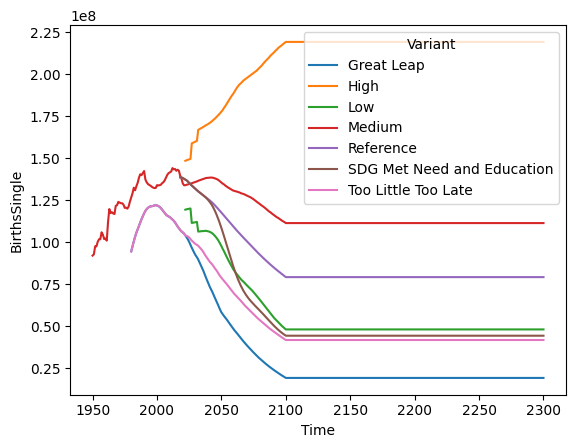

In [59]:
sns.lineplot(df_comb_extend, x="Time", y="BirthsSingle", hue="Variant")

In [60]:
cumulative_births_comb_ext = df_comb_extend[df_comb_extend.Time > 2022]\
    .droplevel("Variant")\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .BirthsSingle\
    .cumsum()\
    .reset_index()

In [67]:
cumulative_births_ce_bn = cumulative_births_comb_ext
cumulative_births_ce_bn.loc[:, "BirthsBns"] = cumulative_births_ce_bn.loc[:, "BirthsSingle"]/1_000_000_000

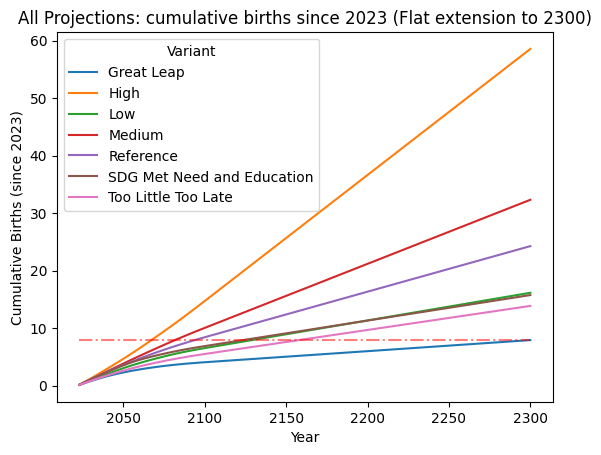

In [69]:
sns.lineplot(data=cumulative_births_ce_bn,
             x="Time",
             y="BirthsBns",
             hue="Variant")
plt.title(f"All Projections: cumulative births since 2023 (Flat extension to {2100 + extrap_len})")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8, 2023, 2100+extrap_len, color="r",linestyle="dashdot", alpha=0.5)
plt.show()

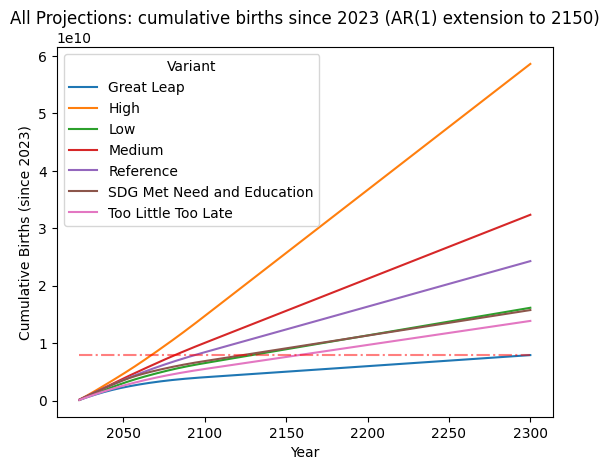

In [62]:
sns.lineplot(data=cumulative_births_comb_ext,
             x="Time",
             y="BirthsSingle",
             hue="Variant")
plt.title("All Projections: cumulative births since 2023 (AR(1) extension to 2150)")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8e9, 2023, 2100+extrap_len, color="r",linestyle="dashdot", alpha=0.5)
plt.show()

In [64]:
cumulative_births_comb_ext[cumulative_births_comb_ext.BirthsSingle >= 8e9]\
    .groupby("Variant")\
    .min("Time")

,Time,BirthsSingle
Variant,,
High,2068,8.051131e+09
Low,2131,8.005052e+09
Medium,2083,8.066832e+09
Reference,2095,8.002094e+09
SDG Met Need and Education,2126,8.016662e+09
Too Little Too Late,2161,8.038735e+09


In [70]:
cumulative_births_ce_bn[cumulative_births_ce_bn.BirthsBns >= 8]\
    .groupby("Variant")\
    .min("Time")

,Time,BirthsSingle,BirthsBns
Variant,,,
High,2068,8.051131e+09,8.051131
Low,2131,8.005052e+09,8.005052
Medium,2083,8.066832e+09,8.066832
Reference,2095,8.002094e+09,8.002094
SDG Met Need and Education,2126,8.016662e+09,8.016662
Too Little Too Late,2161,8.038735e+09,8.038735


In [82]:
df_nona.TPopulation1July.notna().sum()/df_nona.shape[0]
#df.columns
df.columns[df_nona.iloc[-1, :].notna()]

Index(['Unnamed: 0.1', 'index', 'Variant', 'Time', 'BirthsSingle'], dtype='object')

In [71]:
df_nona[df_nona.Time > 2000].groupby("Variant").

,Unnamed: 0.1,index,Unnamed: 0,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,...,Q0060Female,Q1550,Q1550Male,Q1550Female,Q1560,Q1560Male,Q1560Female,NetMigrations,CNMR,BirthsSingle
51,51,51,51.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,214.9626,98.9656,117.5246,79.7179,180.1983,216.2801,142.6434,0.0,0.0,133877730.0
52,52,52,52.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,210.9571,97.8975,116.2636,78.8532,178.1477,214.1085,140.7457,0.0,0.0,134020459.0
53,53,53,53.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,206.4814,96.9070,115.2101,77.9253,176.3398,212.4988,138.7641,0.0,0.0,134302047.0
54,54,54,54.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,203.3061,96.1681,114.0535,77.6212,174.5507,210.2669,137.4986,0.0,0.0,135228145.0
55,55,55,55.0,1.0,900.0,NaN,NaN,NaN,1.0,1.0,...,197.0843,94.0423,112.0666,75.3388,171.3201,207.5126,133.7829,0.0,0.0,135800237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43856346.0
716,716,238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43313897.0
717,717,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42804561.0
718,718,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42319098.0


In [85]:
cumulative_births = df_nona[df_nona.Time > 2022]\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .BirthsSingle\
    .cumsum()\
    .reset_index()

In [86]:
cumulative_births_un_med = cumulative_births[cumulative_births.Variant=="Medium"]

In [96]:
cumul_birth_diff = cumulative_births.merge(cumulative_births_un_med, on="Time", suffixes=("","_ref")).loc[:, ("Variant", "Time", "BirthsSingle", "BirthsSingle_ref")]

In [97]:
cumul_birth_diff.loc[:, "BirthDiff"] = cumul_birth_diff.BirthsSingle - cumul_birth_diff.BirthsSingle_ref

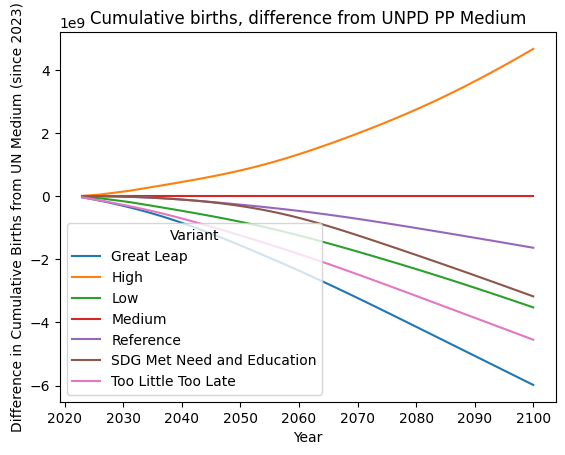

In [99]:
sns.lineplot(cumul_birth_diff,
            x="Time",
            y="BirthDiff",
            hue="Variant")
plt.title("Cumulative births, difference from UNPD PP Medium")
plt.xlabel("Year")
plt.ylabel("Difference in Cumulative Births from UN Medium (since 2023)")
plt.show()

In [107]:
diff_un_med_2100 = cumul_birth_diff[cumul_birth_diff.Time==2100]
diff_un_med_2100.loc[:, "BirthDiffBn"] = diff_un_med_2100.BirthDiff/1_000_000_000
diff_un_med_2100.loc[:, "BirthAbsDiffBn"] = diff_un_med_2100.BirthDiff.abs()/1_000_000_000
diff_un_med_2100.loc[:, "BirthAbsDiff"] = diff_un_med_2100.BirthDiff.abs()


/tmp/ipykernel_27876/3560472051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_un_med_2100.loc[:, "BirthDiffBn"] = diff_un_med_2100.BirthDiff/1_000_000_000
/tmp/ipykernel_27876/3560472051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_un_med_2100.loc[:, "BirthAbsDiffBn"] = diff_un_med_2100.BirthDiff.abs()/1_000_000_000
/tmp/ipykernel_27876/3560472051.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [117]:
diff_un_med_2100.reset_index().drop(columns=["index", "BirthsSingle_ref"]).to_csv("../../data/prepared_data/slide_data/diffs_2100.csv")

In [119]:
datapaths = [ # load these iteratively
    "../../data/prepared_data/gbd_world_births.csv",
    "../../data/prepared_data/unpd_world_indicators.csv",
    "../../data/prepared_data/cumulative_births_unpd_all_countries.csv",
    "../../data/prepared_data/e4a_combined_labelled.csv"
]

df_gbd_births, df_unpd_world, df_unpd_cumul, df_e4a = [
    pd.read_csv(dpath) for dpath in datapaths
]

In [132]:
interp_df = df_unpd_world[(2010 <= df_unpd_world.Time) & (df_unpd_world.Time <= 2025) & (df_unpd_world.Variant=="Medium")].loc[:, ("Time", "TPopulation1Jan")]

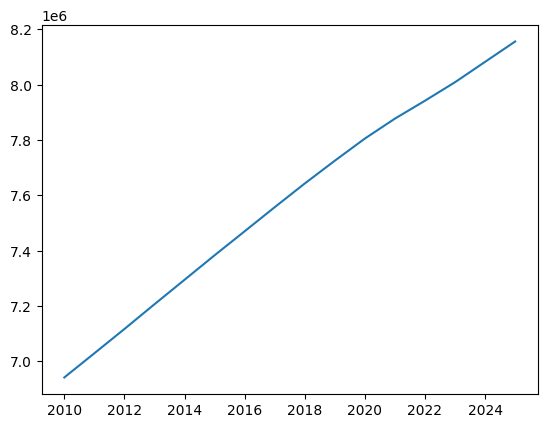

In [133]:
plt.plot(interp_df.Time, interp_df.TPopulation1Jan)

In [134]:
from scipy.interpolate import CubicSpline

In [135]:
cs = CubicSpline(interp_df.Time, interp_df.TPopulation1Jan)

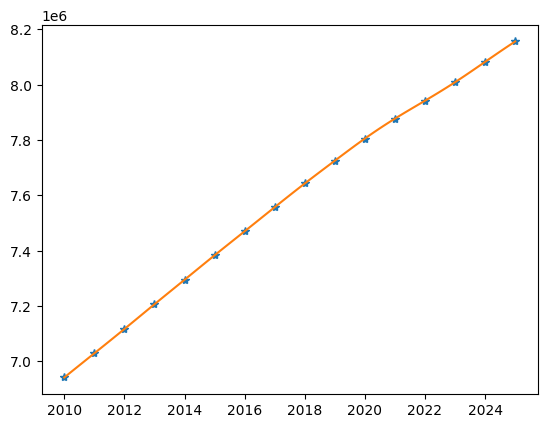

In [159]:
plt.plot(interp_df.Time, interp_df.TPopulation1Jan, "*")
test_x = np.linspace(interp_df.Time.iloc[0], interp_df.Time.iloc[-1], 100)
plt.plot(test_x, cs(test_x))
plt.show()

In [139]:
mon_names = ("Jan", "Feb", "Mar", "Apr", "May", "June", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec")
months = {mon: i/12.0 for i, mon in enumerate(mon_names)}

In [142]:
for year in range(2020, 2025):
    for mon, inc in months.items():
        print(f"Pop. in {mon} {year}: {cs(year + inc)}")

Pop. in Jan 2020: 7804973.773
Pop. in Feb 2020: 7811339.045698139
Pop. in Mar 2020: 7817635.852939209
Pop. in Apr 2020: 7823864.6204585815
Pop. in May 2020: 7830025.773991685
Pop. in June 2020: 7836119.739273947
Pop. in Jul 2020: 7842146.9420407405
Pop. in Aug 2020: 7848107.808027494
Pop. in Sept 2020: 7854002.762969631
Pop. in Oct 2020: 7859832.232602529
Pop. in Nov 2020: 7865596.642661614
Pop. in Dec 2020: 7871296.418882313
Pop. in Jan 2021: 7876931.987
Pop. in Feb 2021: 7882504.902828767
Pop. in Mar 2021: 7888021.242497359
Pop. in Apr 2021: 7893488.212213146
Pop. in May 2021: 7898913.018183536
Pop. in June 2021: 7904302.866615941
Pop. in Jul 2021: 7909664.963717728
Pop. in Aug 2021: 7915006.515696308
Pop. in Sept 2021: 7920334.72875909
Pop. in Oct 2021: 7925656.809113445
Pop. in Nov 2021: 7930979.962966782
Pop. in Dec 2021: 7936311.396526511
Pop. in Jan 2022: 7941658.316
Pop. in Feb 2022: 7947027.290838034
Pop. in Mar 2022: 7952422.343464898
Pop. in Apr 2022: 7957846.859548207
Pop. 

In [144]:
df_unpd_world[(df_unpd_world.Variant=="Medium") & (df_unpd_world.Time==2023)].TPopulation1Jan

73    8008551.995
Name: TPopulation1Jan, dtype: float64

In [162]:
unpd_84 = {"year": [], "population": []}
for yr, pop in {
    2000: 6_122_000_000,
    2005: 6_559_000_000,
    2010: 6_989_000_000,
    2015: 7_414_000_000,
    2020: 7_822_000_000,
    2025: 8_206_000_000
}.items():
    unpd_84["year"].append(yr)
    unpd_84["population"].append(pop)
df_84 = pd.DataFrame.from_dict(unpd_84)

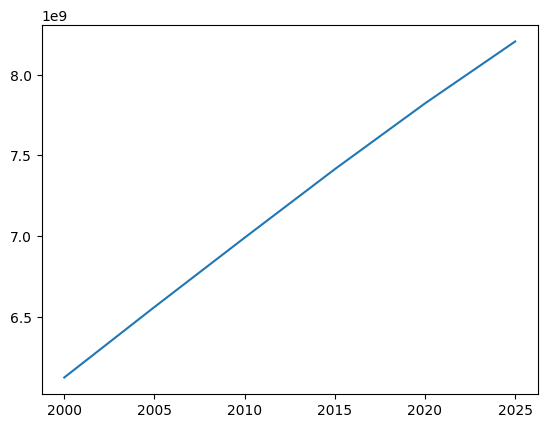

In [163]:
plt.plot(df_84.year, df_84.population)

In [164]:
cs84 = CubicSpline(df_84.year, df_84.population)

In [165]:
for year in range(2020, 2025):
    for mon, inc in months.items():
        print(f"Pop. in {mon} {year}: {cs84(year + inc)}")

Pop. in Jan 2020: 7822000000.0
Pop. in Feb 2020: 7828609811.162545
Pop. in Mar 2020: 7835212933.744862
Pop. in Apr 2020: 7841809345.833334
Pop. in May 2020: 7848399025.514398
Pop. in June 2020: 7854981950.874492
Pop. in Jul 2020: 7861558100.0
Pop. in Aug 2020: 7868127450.977361
Pop. in Sept 2020: 7874689981.89301
Pop. in Oct 2020: 7881245670.833333
Pop. in Nov 2020: 7887794495.8847685
Pop. in Dec 2020: 7894336435.133751
Pop. in Jan 2021: 7900871466.666667
Pop. in Feb 2021: 7907399568.569953
Pop. in Mar 2021: 7913920718.930048
Pop. in Apr 2021: 7920434895.833333
Pop. in May 2021: 7926942077.366249
Pop. in June 2021: 7933442241.615232
Pop. in Jul 2021: 7939935366.666667
Pop. in Aug 2021: 7946421430.60699
Pop. in Sept 2021: 7952900411.52264
Pop. in Oct 2021: 7959372287.5
Pop. in Nov 2021: 7965837036.625509
Pop. in Dec 2021: 7972294636.985603
Pop. in Jan 2022: 7978745066.666666
Pop. in Feb 2022: 7985188303.755137
Pop. in Mar 2022: 7991624326.337454
Pop. in Apr 2022: 7998053112.5
Pop. in Ma

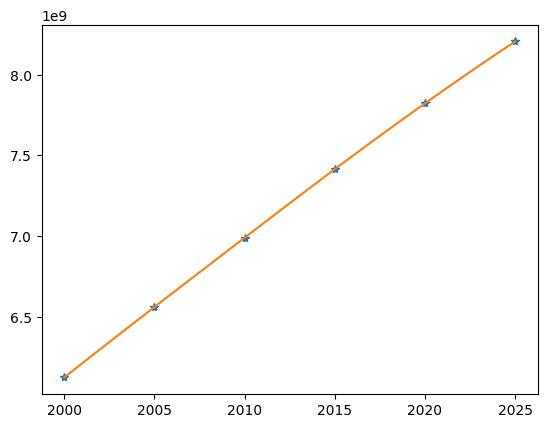

In [166]:
plt.plot(df_84.year, df_84.population, "*")
test_x = np.linspace(df_84.year.iloc[0], df_84.year.iloc[-1], 100)
plt.plot(test_x, cs84(test_x))
plt.show()

In [168]:
#df_gbd_births, df_unpd_world, df_unpd_cumul, df_e4a
df_e4a.loc[:, "Population_p"] = df_e4a["Population Mp"]*1_000_000

In [174]:
df_e4a

,Unnamed: 0,year_id,"""Births Mp/y""","""Population below 15 k$/p/y Mp""",Population Mp,Working age population Mp,scenario,Births,Population_p
0,0,1980,94.600006,3914.770131,4420.000000,1977.142857,Great Leap,94600005,4.420000e+09
1,1,1981,97.659449,3940.186362,4486.124146,2041.694903,Great Leap,97659448,4.486124e+09
2,2,1982,100.569083,3980.744800,4555.361670,2107.341551,Great Leap,100569082,4.555362e+09
3,3,1983,103.316901,4030.359977,4627.691896,2174.128849,Great Leap,103316901,4.627692e+09
4,4,1984,105.734739,4074.497332,4702.930437,2243.064314,Great Leap,105734738,4.702930e+09
...,...,...,...,...,...,...,...,...,...
237,116,2096,43.856347,9.083426,7508.270472,5122.065838,Too Little Too Late,43856346,7.508270e+09
238,117,2097,43.313897,7.029385,7456.727277,5085.789459,Too Little Too Late,43313897,7.456727e+09
239,118,2098,42.804562,9.747495,7404.809645,5049.026879,Too Little Too Late,42804561,7.404810e+09
240,119,2099,42.319098,10.160279,7352.526429,5011.815145,Too Little Too Late,42319098,7.352526e+09


In [264]:
e4a_tmp = df_nona[
    df_nona\
        .Variant.apply(
            lambda v: v in ("Great Leap", "Too Little Too Late")
        )]\
    .merge(
        df_e4a.loc[:,["scenario", "year_id", "Population_p"]],
        left_on=["Variant", "Time"],
        right_on=["scenario", "year_id"],
        suffixes=("", "_new")
)

e4a_tmp['TPopulation1Jan'] = e4a_tmp.Population_p/1_000

In [265]:
df = pd.concat([df_nona[df_nona.Variant.apply(lambda v: v not in ("Great Leap", "Too Little Too Late"))], e4a_tmp.loc[:, df_nona.columns]]).reset_index().drop(columns="index")
#df.loc[:,"Population"] = df.TPopulation1Jan*1_000

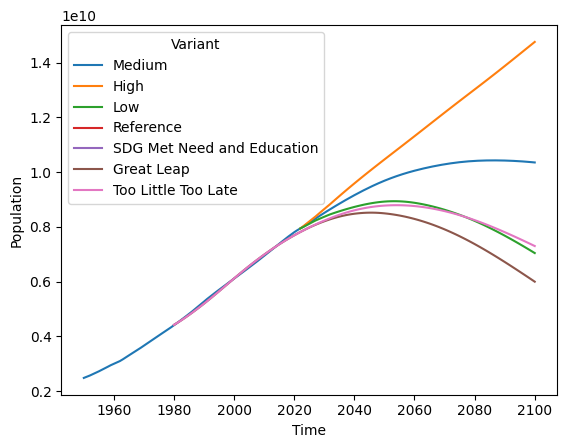

In [249]:
sns.lineplot(df,
            x="Time", y="Population", hue="Variant")
plt.show()

In [250]:
df[df.Time > 2000].groupby("Variant").Population.max()

Variant
Great Leap                    8.519795e+09
High                          1.476235e+10
Low                           8.938561e+09
Medium                        1.043105e+10
Reference                              NaN
SDG Met Need and Education             NaN
Too Little Too Late           8.792909e+09
Name: Population, dtype: float64

In [251]:
df[(df.Time > 2000) & (df.Variant.apply(lambda v: v in ("Reference", "SDG Met Need and Education")))].TPopulation1Jan

309   NaN
310   NaN
311   NaN
312   NaN
313   NaN
       ..
470   NaN
471   NaN
472   NaN
473   NaN
474   NaN
Name: TPopulation1Jan, Length: 166, dtype: float64

In [252]:
data_folder = "../../data/prepared_data/"
gbd_scenarios_pop = pd.read_csv(data_folder + "gbd_scenarios_pop.csv")

In [253]:
gbd_scenarios_pop

,Unnamed: 0,location_id,location_name,sex_id,sex,age_group_id,age_group_name,year_id,measure_id,measure_name,metric_id,metric_name,scenario,scenario_name,val,upper,lower
0,83,1,Global,3,Both,22,All Ages,2018,44,Population,1,Number,0,Reference,7.723391e+09,7.728632e+09,7.718907e+09
1,84,1,Global,3,Both,22,All Ages,2019,44,Population,1,Number,0,Reference,7.805529e+09,7.815100e+09,7.797069e+09
2,85,1,Global,3,Both,22,All Ages,2020,44,Population,1,Number,0,Reference,7.886694e+09,7.902986e+09,7.872579e+09
3,86,1,Global,3,Both,22,All Ages,2021,44,Population,1,Number,0,Reference,7.966665e+09,7.990711e+09,7.945987e+09
4,87,1,Global,3,Both,22,All Ages,2022,44,Population,1,Number,0,Reference,8.045375e+09,8.078295e+09,8.016628e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37179,92955,218,Togo,3,Both,22,All Ages,2096,44,Population,1,Number,3,SDG Met Need and Education,8.382147e+06,1.120999e+07,6.511280e+06
37180,92956,218,Togo,3,Both,22,All Ages,2097,44,Population,1,Number,3,SDG Met Need and Education,8.261903e+06,1.112307e+07,6.375342e+06
37181,92957,218,Togo,3,Both,22,All Ages,2098,44,Population,1,Number,3,SDG Met Need and Education,8.140833e+06,1.103458e+07,6.240393e+06
37182,92958,218,Togo,3,Both,22,All Ages,2099,44,Population,1,Number,3,SDG Met Need and Education,8.018700e+06,1.094469e+07,6.101730e+06


In [254]:
gbd_scenarios_pop.loc[gbd_scenarios_pop.location_name=="Global", ("year_id", "scenario_name", "val")]

,year_id,scenario_name,val
0,2018,Reference,7.723391e+09
1,2019,Reference,7.805529e+09
2,2020,Reference,7.886694e+09
3,2021,Reference,7.966665e+09
4,2022,Reference,8.045375e+09
...,...,...,...
161,2096,SDG Met Need and Education,6.579249e+09
162,2097,SDG Met Need and Education,6.507213e+09
163,2098,SDG Met Need and Education,6.434835e+09
164,2099,SDG Met Need and Education,6.362193e+09


In [266]:
gbd_tmp = df_nona[
    df_nona\
        .Variant.apply(
            lambda v: v in ("Reference", "SDG Met Need and Education")
        )]\
    .merge(
        gbd_scenarios_pop.loc[gbd_scenarios_pop.location_name=="Global", ("year_id", "scenario_name", "val")],
        left_on=["Variant", "Time"],
        right_on=["scenario_name", "year_id"],
        suffixes=("", "_new")
)

gbd_tmp['TPopulation1Jan'] = gbd_tmp.val/1_000
gbd_tmp

,Unnamed: 0.1,index,Unnamed: 0,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,...,Q1550Female,Q1560,Q1560Male,Q1560Female,NetMigrations,CNMR,BirthsSingle,year_id,scenario_name,val
0,312,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.386403e+08,2018,Reference,7.723391e+09
1,313,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.385584e+08,2019,Reference,7.805529e+09
2,314,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.382425e+08,2020,Reference,7.886694e+09
3,315,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.377860e+08,2021,Reference,7.966665e+09
4,316,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.373465e+08,2022,Reference,8.045375e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,473,161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.665493e+07,2096,SDG Met Need and Education,6.579249e+09
162,474,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.604602e+07,2097,SDG Met Need and Education,6.507213e+09
163,475,163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.546677e+07,2098,SDG Met Need and Education,6.434835e+09
164,476,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.491790e+07,2099,SDG Met Need and Education,6.362193e+09


In [273]:
cols_keep = ['SortOrder', 'LocID', 'Notes', 'ISO3_code', 'ISO2_code', 'SDMX_code',
       'LocTypeID', 'LocTypeName', 'ParentID', 'Location', 'VarID', 'Variant',
       'Time', 'TPopulation1Jan', 'TPopulation1July', 'TPopulationMale1July',
       'TPopulationFemale1July', 'PopDensity', 'PopSexRatio', 'MedianAgePop',
       'NatChange', 'NatChangeRT', 'PopChange', 'PopGrowthRate',
       'DoublingTime', 'Births', 'Births1519', 'CBR', 'TFR', 'NRR', 'MAC',
       'SRB', 'Deaths', 'DeathsMale', 'DeathsFemale', 'CDR', 'LEx', 'LExMale',
       'LExFemale', 'LE15', 'LE15Male', 'LE15Female', 'LE65', 'LE65Male',
       'LE65Female', 'LE80', 'LE80Male', 'LE80Female', 'InfantDeaths', 'IMR',
       'LBsurvivingAge1', 'Under5Deaths', 'Q5', 'Q0040', 'Q0040Male',
       'Q0040Female', 'Q0060', 'Q0060Male', 'Q0060Female', 'Q1550',
       'Q1550Male', 'Q1550Female', 'Q1560', 'Q1560Male', 'Q1560Female',
       'NetMigrations', 'CNMR', 'BirthsSingle']

df = pd.concat(
    [df[df.Variant.apply(lambda v: v not in ("Reference", "SDG Met Need and Education"))], 
     gbd_tmp.loc[:, cols_keep]]).reset_index().drop(columns="index")
df.loc[:,"Population"] = df.TPopulation1Jan*1_000

In [292]:
df.to_csv("../../data/prepared_data/slide_data/all_projections_births_pop.csv", index=None)

In [274]:
df.Variant.value_counts()

Variant
Medium                        151
Great Leap                    121
Too Little Too Late           121
Reference                      83
SDG Met Need and Education     83
High                           79
Low                            79
Name: count, dtype: int64

In [277]:
pop_maxima = df[df.Time > 2000].groupby("Variant").Population.max()

In [280]:
pop_maxima.to_frame().to_csv("../../data/prepared_data/slide_data/population_maxima.csv")

In [281]:
del pop_maxima

In [282]:
tmp = pd.read_csv("../../data/prepared_data/unpd_large.csv")

In [283]:
tmp.columns

Index(['Unnamed: 0', 'Variant', 'Region, subregion, country or area *', 'Type',
       'Year', 'Total Population, as of 1 July (thousands)',
       'Male Population, as of 1 July (thousands)',
       'Female Population, as of 1 July (thousands)',
       'Population Density, as of 1 July (persons per square km)',
       'Population Sex Ratio, as of 1 July (males per 100 females)',
       'Median Age, as of 1 July (years)',
       'Natural Change, Births minus Deaths (thousands)',
       'Population Change (thousands)', 'Population Growth Rate (percentage)',
       'Births (thousands)', 'Births by women aged 15 to 19 (thousands)',
       'Total Fertility Rate (live births per woman)',
       'Mean Age Childbearing (years)', 'Total Deaths (thousands)',
       'Male Deaths (thousands)', 'Female Deaths (thousands)',
       'Life Expectancy at Birth, both sexes (years)',
       'Male Life Expectancy at Birth (years)',
       'Female Life Expectancy at Birth (years)',
       'Net Number of Mi

In [286]:
un_med = tmp[tmp.Variant=="Medium"]

In [287]:
del tmp

In [288]:
un_med

,Unnamed: 0,Variant,"Region, subregion, country or area *",Type,Year,"Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)",...,Male Deaths (thousands),Female Deaths (thousands),"Life Expectancy at Birth, both sexes (years)",Male Life Expectancy at Birth (years),Female Life Expectancy at Birth (years),Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)","Total Population, as of 1 July",Total Population (Billions),Births (Millions)
43186,0,Medium,WORLD,World,2022,7975105.156,4008579.598,3966525.558,61.157,101.06,...,36127.636,30968.931,71.713,69.144,74.397,0,0,7.975105e+09,7.975105,133990.599
43187,1,Medium,WORLD,World,2023,8045311.447,4042987.695,4002323.752,61.696,101.016,...,32662.05,28098.1,73.357,70.793,75.988,0,0,8.045311e+09,8.045311,134279.612
43188,2,Medium,WORLD,World,2024,8118835.999,4079164.815,4039671.184,62.259,100.978,...,32786.443,28167.462,73.669,71.094,76.309,0,0,8.118836e+09,8.118836,134484.559
43189,3,Medium,WORLD,World,2025,8191988.453,4115098.916,4076889.537,62.820,100.937,...,33311.018,28625.792,73.789,71.209,76.436,0,0,8.191988e+09,8.191988,134712.128
43190,4,Medium,WORLD,World,2026,8264364.509,4150587.873,4113776.637,63.375,100.895,...,33836.988,29091.955,73.948,71.366,76.597,0,0,8.264365e+09,8.264365,134907.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65775,22593,Medium,Wallis and Futuna Islands,Country/Area,2096,10.087,5.019,5.068,72.050,99.033,...,0.058,0.064,89.18,88.601,89.692,-0.01,-0.991,1.008700e+04,0.000010,0.086
65776,22594,Medium,Wallis and Futuna Islands,Country/Area,2097,10.036,4.994,5.042,71.686,99.048,...,0.059,0.064,89.28,88.701,89.799,-0.01,-0.995,1.003600e+04,0.000010,0.086
65777,22595,Medium,Wallis and Futuna Islands,Country/Area,2098,9.989,4.971,5.018,71.350,99.063,...,0.06,0.064,89.409,88.801,89.963,-0.01,-1,9.989000e+03,0.000010,0.085
65778,22596,Medium,Wallis and Futuna Islands,Country/Area,2099,9.940,4.947,4.992,71.000,99.099,...,0.061,0.065,89.511,88.903,90.072,-0.01,-1.005,9.940000e+03,0.000010,0.085


In [291]:
un_med[un_med["Total Population (Billions)"] == un_med["Total Population (Billions)"].max()].to_csv("../../")

,Unnamed: 0,Variant,"Region, subregion, country or area *",Type,Year,"Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)",...,Male Deaths (thousands),Female Deaths (thousands),"Life Expectancy at Birth, both sexes (years)",Male Life Expectancy at Birth (years),Female Life Expectancy at Birth (years),Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)","Total Population, as of 1 July",Total Population (Billions),Births (Millions)
43250,64,Medium,WORLD,World,2086,1.043093e+07,5192308.611,5238617.669,79.99,99.116,...,61480.091,57733.292,80.797,78.54,83.16,0,0,1.043093e+10,10.430926,118975.344


In [294]:
un_med.columns

Index(['Unnamed: 0', 'Variant', 'Region, subregion, country or area *', 'Type',
       'Year', 'Total Population, as of 1 July (thousands)',
       'Male Population, as of 1 July (thousands)',
       'Female Population, as of 1 July (thousands)',
       'Population Density, as of 1 July (persons per square km)',
       'Population Sex Ratio, as of 1 July (males per 100 females)',
       'Median Age, as of 1 July (years)',
       'Natural Change, Births minus Deaths (thousands)',
       'Population Change (thousands)', 'Population Growth Rate (percentage)',
       'Births (thousands)', 'Births by women aged 15 to 19 (thousands)',
       'Total Fertility Rate (live births per woman)',
       'Mean Age Childbearing (years)', 'Total Deaths (thousands)',
       'Male Deaths (thousands)', 'Female Deaths (thousands)',
       'Life Expectancy at Birth, both sexes (years)',
       'Male Life Expectancy at Birth (years)',
       'Female Life Expectancy at Birth (years)',
       'Net Number of Mi

In [301]:
un_med_prop = un_med.merge(
    un_med.loc[un_med["Region, subregion, country or area *"]=="WORLD", ("Year", "Total Population (Billions)")],
    on="Year",
    suffixes=("", "_world"))

In [306]:
un_med_prop.loc[:, "TotalPopPercentageOfGlobal"] = un_med_prop["Total Population (Billions)"]/un_med_prop["Total Population (Billions)_world"]


In [308]:
un_med_prop.to_csv("../../data/prepared_data/slide_data/un_med_percent_pop.csv", index=None)

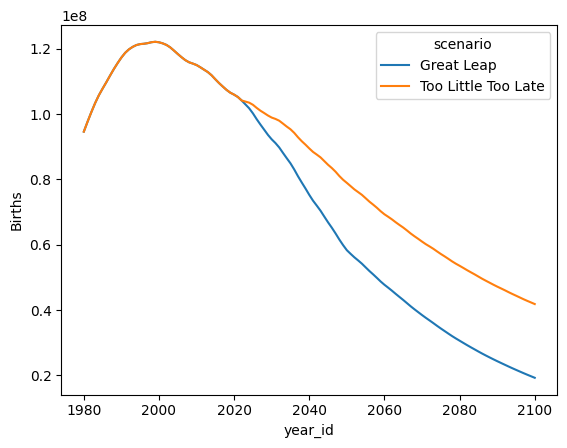

In [315]:
sns.lineplot(data=df_e4a, x="year_id", y="Births", hue="scenario")
plt.show()

In [316]:
df_e4a

,Unnamed: 0,year_id,"""Births Mp/y""","""Population below 15 k$/p/y Mp""",Population Mp,Working age population Mp,scenario,Births,Population_p
0,0,1980,94.600006,3914.770131,4420.000000,1977.142857,Great Leap,94600005,4.420000e+09
1,1,1981,97.659449,3940.186362,4486.124146,2041.694903,Great Leap,97659448,4.486124e+09
2,2,1982,100.569083,3980.744800,4555.361670,2107.341551,Great Leap,100569082,4.555362e+09
3,3,1983,103.316901,4030.359977,4627.691896,2174.128849,Great Leap,103316901,4.627692e+09
4,4,1984,105.734739,4074.497332,4702.930437,2243.064314,Great Leap,105734738,4.702930e+09
...,...,...,...,...,...,...,...,...,...
237,116,2096,43.856347,9.083426,7508.270472,5122.065838,Too Little Too Late,43856346,7.508270e+09
238,117,2097,43.313897,7.029385,7456.727277,5085.789459,Too Little Too Late,43313897,7.456727e+09
239,118,2098,42.804562,9.747495,7404.809645,5049.026879,Too Little Too Late,42804561,7.404810e+09
240,119,2099,42.319098,10.160279,7352.526429,5011.815145,Too Little Too Late,42319098,7.352526e+09


In [317]:
df.columns

Index(['level_0', 'Unnamed: 0.1', 'Unnamed: 0', 'SortOrder', 'LocID', 'Notes',
       'ISO3_code', 'ISO2_code', 'SDMX_code', 'LocTypeID', 'LocTypeName',
       'ParentID', 'Location', 'VarID', 'Variant', 'Time', 'TPopulation1Jan',
       'TPopulation1July', 'TPopulationMale1July', 'TPopulationFemale1July',
       'PopDensity', 'PopSexRatio', 'MedianAgePop', 'NatChange', 'NatChangeRT',
       'PopChange', 'PopGrowthRate', 'DoublingTime', 'Births', 'Births1519',
       'CBR', 'TFR', 'NRR', 'MAC', 'SRB', 'Deaths', 'DeathsMale',
       'DeathsFemale', 'CDR', 'LEx', 'LExMale', 'LExFemale', 'LE15',
       'LE15Male', 'LE15Female', 'LE65', 'LE65Male', 'LE65Female', 'LE80',
       'LE80Male', 'LE80Female', 'InfantDeaths', 'IMR', 'LBsurvivingAge1',
       'Under5Deaths', 'Q5', 'Q0040', 'Q0040Male', 'Q0040Female', 'Q0060',
       'Q0060Male', 'Q0060Female', 'Q1550', 'Q1550Male', 'Q1550Female',
       'Q1560', 'Q1560Male', 'Q1560Female', 'NetMigrations', 'CNMR',
       'BirthsSingle', 'Population

<Axes: xlabel='Time', ylabel='TFR'>

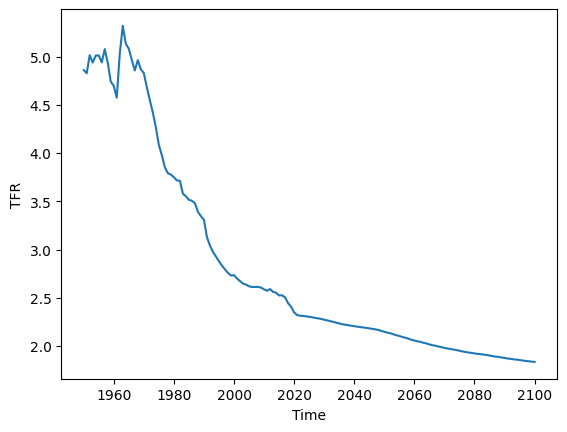

In [320]:
sns.lineplot(df.loc[df.Variant=="Medium", ("Time", "TFR")],
            x="Time", y="TFR")

In [321]:
tfr_med = df.loc[df.Variant=="Medium", ("Time", "TFR")]
tfr_med.loc[tfr_med.TFR==tfr_med.TFR.max(), :]

,Time,TFR
13,1963,5.3169


In [324]:
med_med = df.loc[df.Variant=="Medium", ("Time", "MedianAgePop")]
med_med.loc[med_med.MedianAgePop==med_med.MedianAgePop.min(), :]

,Time,MedianAgePop
20,1970,20.3198


In [335]:
un_med.loc[:,"diff"] = un_med\
    .sort_values(["Region, subregion, country or area *", "Year"], ascending=[1,1])\
    .groupby("Region, subregion, country or area *")["Total Population (Billions)"].diff()

/tmp/ipykernel_27876/1375288410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  un_med.loc[:,"diff"] = un_med\


In [353]:
un_med_diffs = un_med.loc[(un_med.Year==2023) & (un_med.Type=="Country/Area"), ('Year','Region, subregion, country or area *','Total Population (Billions)','diff')]

falling_index = un_med_diffs["diff"] < 0

In [354]:
un_med.Type.value_counts()

Type
Country/Area         18723
Subregion             1659
SDG region             632
Income Group           474
Region                 474
Development Group      395
Special other          158
World                   79
Name: count, dtype: int64

In [355]:
sum(falling_index)

40

In [358]:
un_med_diffs.loc[falling_index, ("Region, subregion, country or area *","Total Population (Billions)")]["Total Population (Billions)"].sum()

2.06358479

In [372]:
un_med.loc[:,"Births (Millions)"] = un_med["Births (Millions)"].apply(lambda x: float(x) if x!="..." else np.nan )

In [398]:
un_med[(un_med.Year <= 2083) & (un_med.Year > 2022) & (un_med.Type=="Development Group")]\
    .groupby("Region, subregion, country or area *")["Births (Millions)"].sum()[["Least developed countries","Less developed regions, excluding least developed countries", "More developed regions"]]\
    .to_csv("../../data/prepared_data/slide_data/development_n9b_strata.csv")

In [361]:
un_med.Type/

Type
Country/Area         18723
Subregion             1659
SDG region             632
Income Group           474
Region                 474
Development Group      395
Special other          158
World                   79
Name: count, dtype: int64

In [408]:
un_med[(un_med.Year <= 2083) & (un_med.Year > 2022) & (un_med.Type=="Income Group")]\
    .groupby("Region, subregion, country or area *")["Births (Millions)"].sum()\
    [["High-income countries","Middle-income countries","Low-income countries","No income group available"]]\
    .to_csv("../../data/prepared_data/slide_data/income_n9b_strata.csv")

In [407]:
un_med[(un_med.Year <= 2083) & (un_med.Year > 2022) & (un_med.Type=="Income Group")]\
    .groupby("Region, subregion, country or area *")["Total Population (Billions)"].sum()\
    [["High-income countries","Upper-middle-income countries", "Lower-middle-income countries","Low-income countries","No income group available"]].sum()

586.5434730320001

In [401]:
un_med.columns

Index(['Unnamed: 0', 'Variant', 'Region, subregion, country or area *', 'Type',
       'Year', 'Total Population, as of 1 July (thousands)',
       'Male Population, as of 1 July (thousands)',
       'Female Population, as of 1 July (thousands)',
       'Population Density, as of 1 July (persons per square km)',
       'Population Sex Ratio, as of 1 July (males per 100 females)',
       'Median Age, as of 1 July (years)',
       'Natural Change, Births minus Deaths (thousands)',
       'Population Change (thousands)', 'Population Growth Rate (percentage)',
       'Births (thousands)', 'Births by women aged 15 to 19 (thousands)',
       'Total Fertility Rate (live births per woman)',
       'Mean Age Childbearing (years)', 'Total Deaths (thousands)',
       'Male Deaths (thousands)', 'Female Deaths (thousands)',
       'Life Expectancy at Birth, both sexes (years)',
       'Male Life Expectancy at Birth (years)',
       'Female Life Expectancy at Birth (years)',
       'Net Number of Mi

In [419]:
df_hdi = pd.read_excel("../../data/unpd_data/HDR21-22_Statistical_Annex_HDI_Table.xlsx", 0, header=4)
df_gii = pd.read_excel("../../data/unpd_data/HDR21-22_Statistical_Annex_GII_Table.xlsx", 0, header=4)

In [425]:
df_hdi_filtered = df_hdi.loc[df_hdi["Human Development Index (HDI) "].notna(), ("Unnamed: 1", "Human Development Index (HDI) ")]


In [432]:
hdi_lookup = df_hdi_filtered.rename(columns={
    "Human Development Index (HDI) ":  "Human Development Index (HDI)",
    "Unnamed: 1": "Country"
}).iloc[2:, :]

In [447]:
df_gii_filtered = df_gii.loc[df_gii["Value"].notna(), ("Unnamed: 1", "Value")]
gii_lookup = df_gii_filtered.rename(columns={
    "Unnamed: 1": "Country", "Value": "Gender Inequality Index (GII)"
}).iloc[1:, :]

In [448]:
gii_lookup

,Country,Gender Inequality Index (GII)
3,Switzerland,0.018
4,Norway,0.016
5,Iceland,0.043
6,"Hong Kong, China (SAR)",..
7,Australia,0.073
...,...,...
217,Sub-Saharan Africa,0.569
219,Least developed countries,0.562
220,Small island developing states,0.461
222,Organisation for Economic Co-operation and Dev...,0.185


In [451]:
#un_med.merge()

un_med.loc[un_med.Type=="Country/Area",:].shape

(18723, 30)

In [453]:
un_med["Region, subregion, country or area *"]

43186                        WORLD
43187                        WORLD
43188                        WORLD
43189                        WORLD
43190                        WORLD
                   ...            
65775    Wallis and Futuna Islands
65776    Wallis and Futuna Islands
65777    Wallis and Futuna Islands
65778    Wallis and Futuna Islands
65779    Wallis and Futuna Islands
Name: Region, subregion, country or area *, Length: 22594, dtype: object

In [455]:
med_hdi = un_med.merge(hdi_lookup, left_on="Region, subregion, country or area *", right_on="Country", suffixes=("",""))

In [456]:
med_hdi.loc[med_hdi.Type=="Country/Area",:].shape

(14615, 32)

In [459]:
#med_hdi = un_med.merge(hdi_lookup, left_on="Region, subregion, country or area *", right_on="Country", suffixes=("",""))
med_hdi.loc[med_hdi.Type=="Country/Area"]["Region, subregion, country or area *"].value_counts()

Region, subregion, country or area *
Burundi      79
Slovenia     79
Croatia      79
Greece       79
Italy        79
             ..
Maldives     79
Nepal        79
Pakistan     79
Sri Lanka    79
Tuvalu       79
Name: count, Length: 185, dtype: int64

In [470]:
missing_country_indexer = ~un_med.loc[un_med.Type=="Country/Area"]["Region, subregion, country or area *"].value_counts().index.isin(
    med_hdi.loc[med_hdi.Type=="Country/Area"]["Region, subregion, country or area *"].value_counts().index
)

In [683]:
un_med.loc[un_med.Type=="Country/Area"]["Region, subregion, country or area *"].value_counts()[missing_country_indexer]

Region, subregion, country or area *
Anguilla                            79
Aruba                               79
Bonaire, Sint Eustatius and Saba    79
British Virgin Islands              79
Cayman Islands                      79
Curaçao                             79
Guadeloupe                          79
Martinique                          79
Montserrat                          79
Faroe Islands                       79
Guernsey                            79
Isle of Man                         79
Jersey                              79
Gibraltar                           79
Holy See                            79
Kosovo (under UNSC res. 1244)       79
Puerto Rico                         79
Saint Barthélemy                    79
Greenland                           79
Saint Pierre and Miquelon           79
United States of America            79
New Caledonia                       79
Guam                                79
Micronesia (Fed. States of)         79
Northern Mariana Islands   

In [652]:
hdi_lookup[hdi_lookup.Country.apply(lambda x: "unite" in x.lower())]

,Country,Human Development Index (HDI)
20,United Kingdom,0.929
23,United States,0.921
28,United Arab Emirates,0.911
165,Tanzania (United Republic of),0.549


In [667]:
gii_lookup[gii_lookup.Country.apply(lambda x: "taiw" in x.lower())]

,Country,Gender Inequality Index (GII)


In [670]:
country_matcher = {
    "Eswatini": "Eswatini (Kingdom of)",
    "United States of America": "United States",
    "Anguilla": "Latin America and the Caribbean",
    "Aruba": "Latin America and the Caribbean",
"Bonaire, Sint Eustatius and Saba": "Latin America and the Caribbean" ,
"British Virgin Islands": "Latin America and the Caribbean",
"Cayman Islands": "Latin America and the Caribbean",
"Curaçao": "Latin America and the Caribbean",
"Guadeloupe": "East Asia and the Pacific",
"Martinique": "Latin America and the Caribbean",
"Montserrat": "Latin America and the Caribbean",
"Faroe Islands": "Europe and Central Asia",
"Guernsey": "Europe and Central Asia",
"Isle of Man": "Europe and Central Asia",
"Jersey": "Europe and Central Asia",
"Gibraltar": "Europe and Central Asia",
"Holy See": "Europe and Central Asia",
"Kosovo (under UNSC res. 1244)": "Albania",
"Puerto Rico": "Latin America and the Caribbean",
"Saint Barthélemy":"Latin America and the Caribbean",
"Greenland": "Europe and Central Asia",
"Saint Pierre and Miquelon": "Canada",
"New Caledonia":"East Asia and the Pacific",
"Guam":"East Asia and the Pacific",
"Micronesia (Fed. States of)":"East Asia and the Pacific",
"Northern Mariana Islands":"East Asia and the Pacific",
"American Samoa":"East Asia and the Pacific",
"Cook Islands":"East Asia and the Pacific",
"French Polynesia":"East Asia and the Pacific",
"Niue":"East Asia and the Pacific",
"Tokelau":"East Asia and the Pacific",
"Bermuda":"Latin America and the Caribbean",
"Saint Martin (French part)": "Latin America and the Caribbean",
"Sint Maarten (Dutch part)":"Latin America and the Caribbean",
"Turks and Caicos Islands":"Latin America and the Caribbean",
"United States Virgin Islands":"Latin America and the Caribbean",
"Falkland Islands (Malvinas)":"Latin America and the Caribbean",
"French Guiana":"Latin America and the Caribbean",
"Western Sahara":"Morocco",
"Mayotte": "Madagascar",
"Réunion":"Madagascar",
"United Republic of Tanzania":"Sub-Saharan Africa",
"Democratic Republic of the Congo": "Congo (Democratic Republic of the)",
"State of Palestine": "Palestine, State of",
"Republic of Moldova":"Moldova (Republic of)",
"China, Hong Kong SAR": "Hong Kong, China (SAR)",
"China, Macao SAR":"China",
"China, Taiwan Province of China":"Hong Kong, China (SAR)",
"Dem. People's Republic of Korea":"Korea (Democratic People's Rep. of)",
"Republic of Korea":"Korea (Republic of)",
"Wallis and Futuna Islands":"East Asia and the Pacific",
}
sum(missing_country_indexer)

52

In [678]:
hdi_lookup.reset_index().drop(columns="index")

,Country,Human Development Index (HDI)
0,Switzerland,0.962
1,Norway,0.961
2,Iceland,0.959
3,"Hong Kong, China (SAR)",0.952
4,Australia,0.951
...,...,...
206,Least developed countries,0.54
207,Small island developing states,0.73
208,Organisation for Economic Co-operation and Dev...,0.899
209,World,0.732


In [682]:
for country, key in country_matcher.items():
    hdi_lookup.loc[-1] = country, hdi_lookup[hdi_lookup.Country==key]["Human Development Index (HDI)"].iloc[0] 
    gii_lookup.loc[-1] = country, gii_lookup[gii_lookup.Country==key]["Gender Inequality Index (GII)"].iloc[0]
    hdi_lookup = hdi_lookup.reset_index().drop(columns="index")
    gii_lookup = gii_lookup.reset_index().drop(columns="index")

In [771]:
un_hdi_gii_merge = un_med.merge(hdi_lookup, left_on="Region, subregion, country or area *", right_on="Country", suffixes=("",""))\
    .merge(gii_lookup, on="Country", suffixes=("",""))

In [772]:
un_hdi_gii_merge.loc[un_hdi_merge.Type=="Country/Area"]["Gender Inequality Index (GII)"].notna().sum()

18644

In [773]:
un_hdi_gii_merge.to_csv("../../data/prepared_data/slide_data/hdi_gii.csv")

In [774]:
un_hdi_gii_merge

,Unnamed: 0,Variant,"Region, subregion, country or area *",Type,Year,"Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)",...,"Total Population, as of 1 July",Total Population (Billions),Births (Millions),diff,Total Population (Percentage of 2023),Total Population (Percentage of current 8bn),Total Population (Percentage of next 8bn),Country,Human Development Index (HDI),Gender Inequality Index (GII)
0,80,Medium,Sub-Saharan Africa,SDG region,2022,1166766.359,581308.38,585457.979,53.363,99.291,...,1.166766e+09,1.166766,39949.955,NaN,NaN,NaN,NaN,Sub-Saharan Africa,0.547,0.569
1,81,Medium,Sub-Saharan Africa,SDG region,2023,1196275.774,596104.403,600171.371,54.712,99.322,...,1.196276e+09,1.196276,40500.544,2.950942e-02,0.148692,0.148692,NaN,Sub-Saharan Africa,0.547,0.569
2,82,Medium,Sub-Saharan Africa,SDG region,2024,1226533.962,611279.15,615254.812,56.096,99.354,...,1.226534e+09,1.226534,41032.289,3.025819e-02,NaN,NaN,NaN,Sub-Saharan Africa,0.547,0.569
3,83,Medium,Sub-Saharan Africa,SDG region,2025,1257334.259,626719.451,630614.809,57.505,99.382,...,1.257334e+09,1.257334,41566.100,3.080030e-02,NaN,NaN,NaN,Sub-Saharan Africa,0.547,0.569
4,84,Medium,Sub-Saharan Africa,SDG region,2026,1288536.936,642353.31,646183.626,58.932,99.407,...,1.288537e+09,1.288537,42114.906,3.120268e-02,NaN,NaN,NaN,Sub-Saharan Africa,0.547,0.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18876,22593,Medium,Wallis and Futuna Islands,Country/Area,2096,10.087,5.019,5.068,72.050,99.033,...,1.008700e+04,0.000010,0.086,-4.500000e-08,NaN,NaN,NaN,Wallis and Futuna Islands,0.749,0.337
18877,22594,Medium,Wallis and Futuna Islands,Country/Area,2097,10.036,4.994,5.042,71.686,99.048,...,1.003600e+04,0.000010,0.086,-5.100000e-08,NaN,NaN,NaN,Wallis and Futuna Islands,0.749,0.337
18878,22595,Medium,Wallis and Futuna Islands,Country/Area,2098,9.989,4.971,5.018,71.350,99.063,...,9.989000e+03,0.000010,0.085,-4.700000e-08,NaN,NaN,NaN,Wallis and Futuna Islands,0.749,0.337
18879,22596,Medium,Wallis and Futuna Islands,Country/Area,2099,9.940,4.947,4.992,71.000,99.099,...,9.940000e+03,0.000010,0.085,-4.900000e-08,NaN,NaN,NaN,Wallis and Futuna Islands,0.749,0.337


In [775]:
def hdi_levels(hdi):
    if type(hdi)==str and hdi.startswith(".."): return "Not available"
    if hdi > 0.8:
        return "Very High"
    elif hdi > 0.7:
        return "High"
    elif hdi > 0.55:
        return "Medium"
    else:
        return "Low"

def gii_levels(hdi):
    if type(hdi)==str and hdi.startswith(".."): return "Not available"
    if hdi > 0.75: # 0.8
        return "Very High"
    elif hdi > 0.5: # 0.7
        return "High"
    elif hdi > 0.25: # 0.55
        return "Medium"
    else:
        return "Low"

#  (0.8-1.0), high (0.7-0.79), medium (0.55-.70), and low (below 0.55

un_hdi_gii_merge.loc[:, "HDI level"] = un_hdi_gii_merge["Human Development Index (HDI)"].apply(hdi_levels)

'''cum_births_hdi = un_hdi_gii_merge[(un_hdi_gii_merge.Year > 2022)]\
    .groupby(["HDI level","Year", "Country"])["Births (Millions)"].sum()\
    .sort_values(["HDI level","Year"], ascending=True)\
    .set_index(["HDI level","Year"])\
    .groupby("HDI level")\
    ["Births (Millions)"]\
    .cumsum()\
    .reset_index()
'''

'cum_births_hdi = un_hdi_gii_merge[(un_hdi_gii_merge.Year > 2022)]    .groupby(["HDI level","Year", "Country"])["Births (Millions)"].sum()    .sort_values(["HDI level","Year"], ascending=True)    .set_index(["HDI level","Year"])    .groupby("HDI level")    ["Births (Millions)"]    .cumsum()    .reset_index()\n'

In [776]:
un_hdi_gii_merge[(un_hdi_gii_merge.Type=="Country/Area") & (un_hdi_gii_merge.Year > 2023) & (un_hdi_gii_merge.Year <=2083)].groupby(["HDI level"])["Births (Millions)"].sum().to_csv("../../data/prepared_data/slide_data/hdi_aggs.csv")

In [783]:
un_hdi_gii_merge.loc[:,"GII level"] = un_hdi_gii_merge["Gender Inequality Index (GII)"].apply(gii_levels)
un_hdi_gii_merge[(un_hdi_gii_merge.Type=="Country/Area") & (un_hdi_gii_merge.Year > 2022) & un_hdi_gii_merge.Year <=2083].groupby(["GII level"])["Births (Millions)"].sum().to_csv("../../data/prepared_data/slide_data/gii_aggs.csv")

In [786]:
indexer = (un_hdi_gii_merge.Type=="Country/Area") & (un_hdi_gii_merge.Year > 2022) & (un_hdi_gii_merge.Year <=2083)

#un_hdi_gii_merge[(un_hdi_gii_merge.Type=="Country/Area") & (un_hdi_gii_merge.Year > 2023) & un_hdi_gii_merge.Year <=2083].groupby(["GII level"])["Births (Millions)"].sum().sum()
#un_hdi_gii_merge[(un_hdi_gii_merge.Type=="Country/Area") & (un_hdi_gii_merge.Year > 2023) & (un_hdi_gii_merge.Year <=2083)]["Births (Millions)"].sum()

un_hdi_gii_merge.loc[indexer, :].groupby(["GII level"])["Births (Millions)"].sum().to_csv("../../data/prepared_data/slide_data/gii_aggs_even.csv")

In [741]:
hdi_gii_ca = un_hdi_gii_merge[un_hdi_gii_merge.Type=="Country/Area"]
hg_n8b = hdi_gii_ca[(hdi_gii_ca.Year>2022) & (hdi_gii_ca.Year <= 2083)]

In [748]:
hg_n8b.rename(columns={"Births (Millions)":"Births (Thousands)"})\
    .groupby("HDI level")\
    ["Births (Thousands)"].sum().to_csv("../../data/prepared_data/slide_data/hdi_aggs.csv")

hg_n8b.rename(columns={"Births (Millions)":"Births (Thousands)"})\
    .groupby("GII level")\
    ["Births (Thousands)"].sum().to_csv("../../data/prepared_data/slide_data/gii_aggs.csv")

In [737]:
hg_n8b[hg_n8b["HDI level"].isna(), "HDI level"] = 

,Unnamed: 0,Variant,"Region, subregion, country or area *",Type,Year,"Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)",...,Births (Millions),diff,Total Population (Percentage of 2023),Total Population (Percentage of current 8bn),Total Population (Percentage of next 8bn),Country,Human Development Index (HDI),Gender Inequality Index (GII),HDI level,GII level
1344,3007,Medium,Somalia,Country/Area,2023,18143.378,9096.52,9046.859,28.921,100.549,...,774.627,5.458670e-04,0.002255,0.002255,NaN,Somalia,..,..,None,None
1345,3008,Medium,Somalia,Country/Area,2024,18706.922,9379.604,9327.317,29.819,100.561,...,788.171,5.635440e-04,NaN,NaN,NaN,Somalia,..,..,None,None
1346,3009,Medium,Somalia,Country/Area,2025,19281.903,9668.299,9613.604,30.736,100.569,...,802.917,5.749810e-04,NaN,NaN,NaN,Somalia,..,..,None,None
1347,3010,Medium,Somalia,Country/Area,2026,19867.185,9961.987,9905.198,31.669,100.573,...,817.449,5.852820e-04,NaN,NaN,NaN,Somalia,..,..,None,None
1348,3011,Medium,Somalia,Country/Area,2027,20463.994,10261.349,10202.645,32.620,100.575,...,832.330,5.968090e-04,NaN,NaN,NaN,Somalia,..,..,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17990,21628,Medium,Nauru,Country/Area,2079,14.380,7.224,7.155,718.975,100.971,...,0.221,-4.900000e-08,NaN,NaN,NaN,Nauru,..,..,None,None
17991,21629,Medium,Nauru,Country/Area,2080,14.322,7.195,7.127,716.100,100.954,...,0.218,-5.800000e-08,NaN,NaN,NaN,Nauru,..,..,None,None
17992,21630,Medium,Nauru,Country/Area,2081,14.258,7.16,7.098,712.900,100.873,...,0.214,-6.400000e-08,NaN,NaN,NaN,Nauru,..,..,None,None
17993,21631,Medium,Nauru,Country/Area,2082,14.191,7.122,7.069,709.550,100.764,...,0.210,-6.700000e-08,NaN,NaN,NaN,Nauru,..,..,None,None


In [491]:
world_pop_2023 = un_med.loc[(un_med.Year==2023) & (un_med.Type=="World")]["Total Population (Billions)"].iloc[0]
world_pop_n8b = un_med.loc[(un_med.Year==2083) & (un_med.Type=="World")]["Total Population (Billions)"].iloc[0]

In [495]:
un_med.loc[un_med.Year==2023, "Total Population (Percentage of current 8bn)"] = un_med.loc[un_med.Year==2023, "Total Population (Billions)"]/world_pop_2023
un_med.loc[un_med.Year==2083, "Total Population (Percentage of next 8bn)"] = un_med.loc[un_med.Year==2083, "Total Population (Billions)"]/world_pop_n8b


/tmp/ipykernel_27876/56882443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  un_med.loc[un_med.Year==2023, "Total Population (Percentage of current 8bn)"] = un_med.loc[un_med.Year==2023, "Total Population (Billions)"]/world_pop_2023
/tmp/ipykernel_27876/56882443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  un_med.loc[un_med.Year==2083, "Total Population (Percentage of next 8bn)"] = un_med.loc[un_med.Year==2083, "Total Population (Billions)"]/world_pop_n8b


In [499]:
living_future = un_med.loc[
    (un_med.Year==2023) | (un_med.Year==2083),
    (
        "Region, subregion, country or area *",
        "Type", "Year", "Total Population (Billions)",
        "Total Population (Percentage of current 8bn)",
        "Total Population (Percentage of next 8bn)")
]

In [500]:
living = living_future.loc[living_future.Year==2023,:]
future = living_future.loc[living_future.Year==2083,:]

In [507]:
living_vs_future = living.merge(future,
             on=("Region, subregion, country or area *","Type"),
             suffixes=("_living", "_future"))\
    .loc[:,("Region, subregion, country or area *",
           "Type",
           "Total Population (Billions)_living",
           "Total Population (Billions)_future",
           "Total Population (Percentage of current 8bn)_living",
           "Total Population (Percentage of next 8bn)_future")]


In [562]:
living_vs_future.loc[:,"Ratio (Future/Living)"] = living_vs_future["Total Population (Billions)_future"] / living_vs_future["Total Population (Billions)_living"]
living_vs_future.loc[:,"Ratio (Future/Living) pct"] = living_vs_future["Total Population (Percentage of next 8bn)_future"] / living_vs_future["Total Population (Percentage of current 8bn)_living"]


<Axes: >

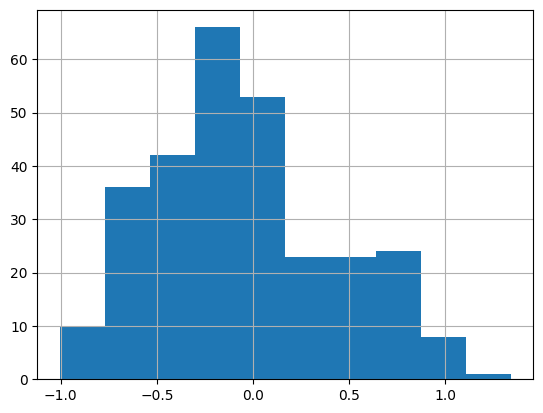

In [564]:
living_vs_future["Ratio (Future/Living) pct"].apply(np.log).hist()

In [520]:
ratio_range = living_vs_future["Ratio (Future/Living)"]).max() - np.ln(living_vs_future["Ratio (Future/Living)"]).min()

AttributeError: module 'numpy' has no attribute 'ln'

<Axes: >

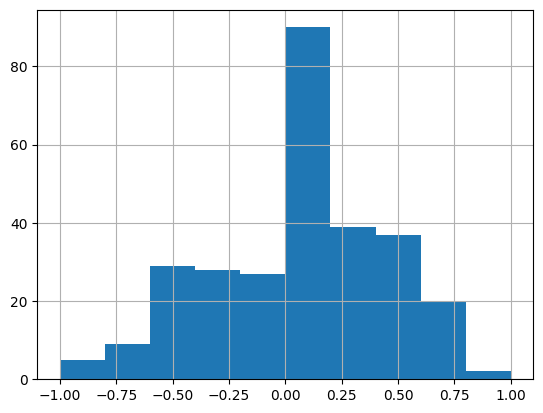

In [536]:
max_val, min_val = living_vs_future["Ratio (Future/Living)"].apply(np.log).max(), living_vs_future["Ratio (Future/Living)"].apply(np.log).min()
(living_vs_future["Ratio (Future/Living)"].apply(np.log).apply(lambda x: x/np.abs(min_val) if x < 0 else x/max_val)).hist()

In [538]:
living_vs_future.loc[:,"Future-living statistic"] = living_vs_future["Ratio (Future/Living)"].apply(np.log).apply(lambda x: x/np.abs(min_val) if x < 0 else x/max_val)

In [540]:
living_vs_future.loc[:, "log-ratio"] = living_vs_future["Ratio (Future/Living)"].apply(np.log)

In [627]:
def compute_stat_params(group_df):
    group_series = group_df["Ratio (Future/Living) pct"].rename({"Ratio (Future/Living) pct":"statistic"}).apply(np.log)
    min_ratio = group_series.min()
    max_ratio = group_series.max()
    range_r = max_ratio - min_ratio
    group_df.loc[:, "statistic"] = group_series.apply(lambda x: (2*(x-min_ratio)/(range_r) -1) if range_r > 0 else 0)
    
    return group_df
    
def compute_stat_params(group_df):
    group_series = group_df["Ratio (Future/Living)"].rename({"Ratio (Future/Living)":"statistic"}).apply(np.log)
    min_ratio = group_series.min()
    max_ratio = group_series.max()
    range_r = max_ratio - min_ratio
    group_df.loc[:, "statistic"] = group_series.apply(lambda x: (2*(x-min_ratio)/(range_r) -1) if range_r > 0 else 0)
    
    return group_df
    
final_l_vs_f = living_vs_future.groupby("Type").apply(compute_stat_params)

In [749]:
stat_df = final_l_vs_f.drop(columns="Type").reset_index()
min_ratio = stat_df["Ratio (Future/Living)"].apply(np.log).min()
range_r = stat_df["Ratio (Future/Living)"].apply(np.log).max() - min_ratio
stat_df.loc[:,"stat_2"] = stat_df["Ratio (Future/Living)"].apply(np.log).apply(lambda x: (2*(x-min_ratio)/(range_r) -1) if range_r > 0 else 0)
stat_df.to_csv("../../data/prepared_data/slide_data/current_future.csv")

/home/niall/.local/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/home/niall/.local/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/home/niall/.local/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/home/niall/.local/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/home/niall/.local/lib/python3.8/site-packages/seaborn/distributions.py:2142

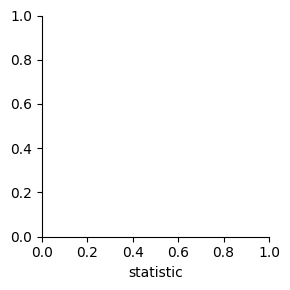

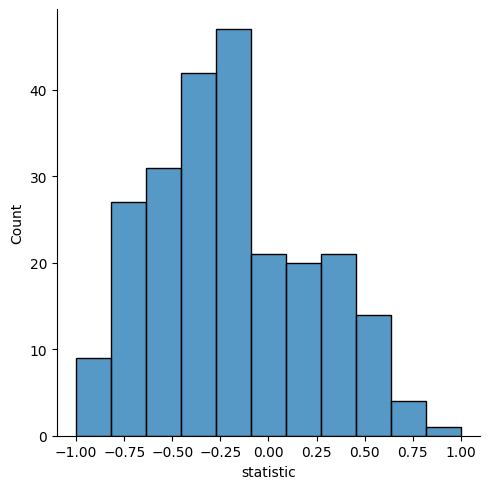

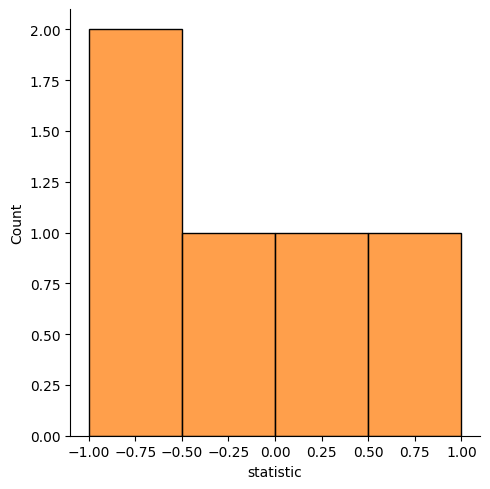

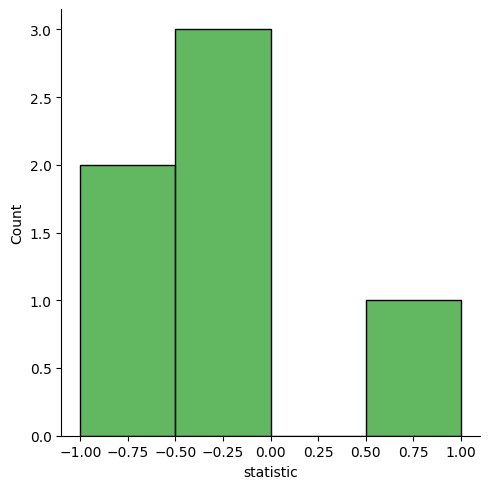

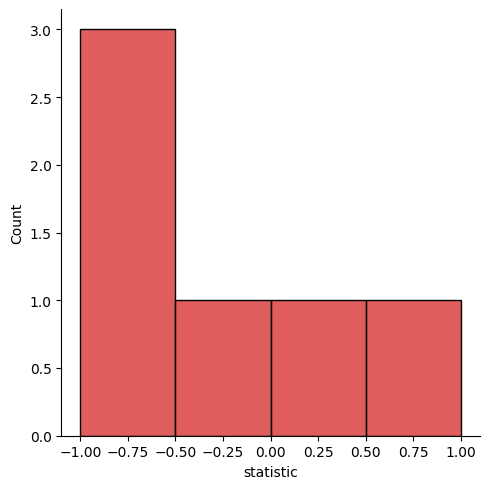

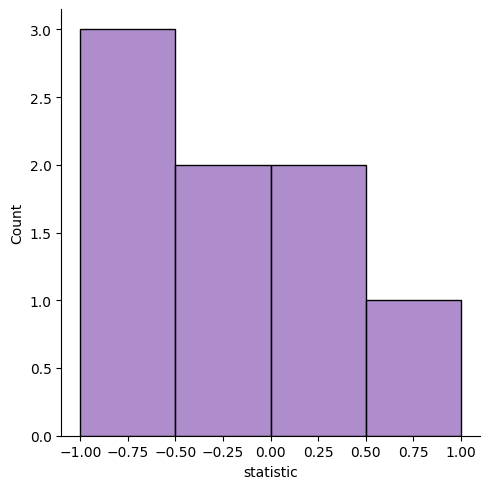

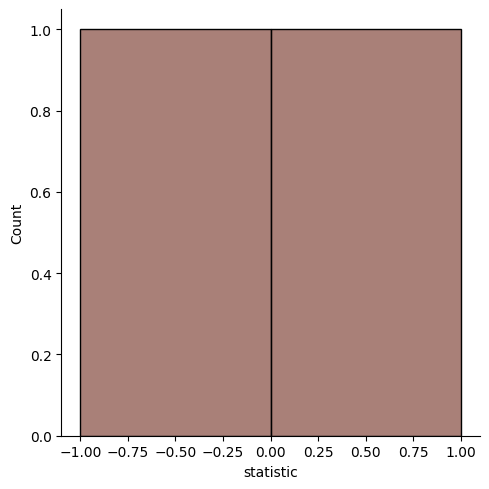

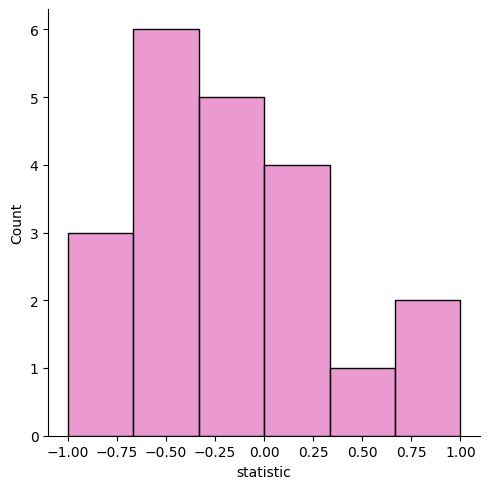

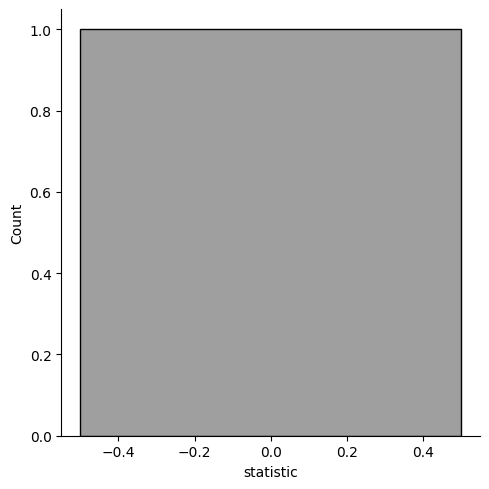

In [629]:
f = sns.FacetGrid(data=stat_df.loc[:, ['Type', 'level_1', 'Region, subregion, country or area *',
       'Total Population (Billions)_living',
       'Total Population (Billions)_future',
       'Total Population (Percentage of current 8bn)_living',
       'Total Population (Percentage of next 8bn)_future',
       'statistic']], hue="Type")
f.map(sns.displot, "statistic", kde=False)

In [631]:
stat_df.groupby("Type").statistic.max()

Type
Country/Area         1.0
Development Group    1.0
Income Group         1.0
Region               1.0
SDG region           1.0
Special other        1.0
Subregion            1.0
World                0.0
Name: statistic, dtype: float64

<Axes: >

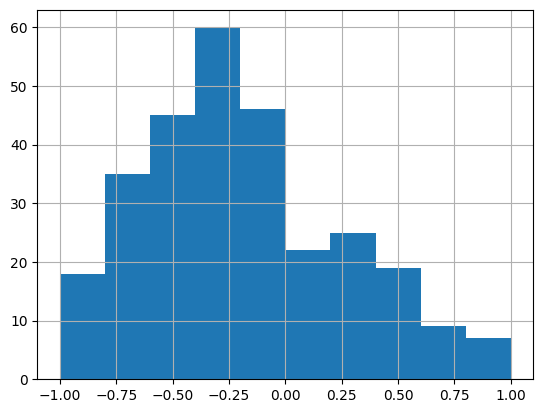

In [632]:
stat_df.statistic.hist()

<Axes: >

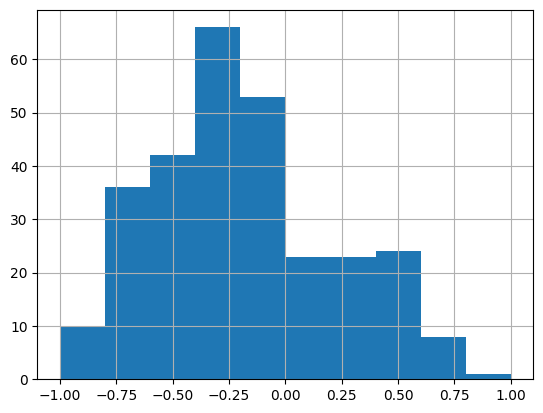

In [754]:
stat_df.stat_2.hist()